<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/MNIST_whyCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ce notebook propose une petite exploration du dataset MNIST (digits de Y. LeCun) afin de mettre en lumière la surprenante puissance des réseaux de neurones.

In [1]:

# Load the dependencies

import numpy as np
import jax
import jax.numpy as jnp


import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
jax.__version__

'0.3.14'

## MNIST dataset: les digits écrits à la main.
(Modified National Institute of Standards and Technology database)

In [3]:
# Load the MNIST dataset

import tensorflow.keras as keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# ObJAX is like Torch, and puts the channel BEFORE the height and width.
# The data starts out as (dataset_size, height=28, width=28)
# We're going to make it (dataset_size, channels=1, height=28, width=28)
x_train = x_train[:,None,:,:]/255.0
x_test = x_test[:,None,:,:]/255.0

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 1, 28, 28), (60000,), (10000, 1, 28, 28), (10000,))

Le dataset consiste en 60,000 imagettes de 28x28 pixels  (niveau de gris [0,1]) de training, et 10,000 imagettes similaires de test. Elles sont toutes labélées par le type de digit visualisé. 

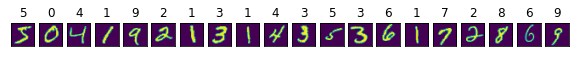

In [ ]:
fig, axs = plt.subplots(1,20,figsize=(10,5))
for i in range(20):
  axs[i].imshow(x_train[i,0])
  axs[i].set_title(f'{y_train[i]}');
  axs[i].set_xticks([])
  axs[i].set_yticks([])

In [ ]:
# Extraction des differents types de digits
zeros = x_train[y_train==0].squeeze()
ones = x_train[y_train==1].squeeze()
twos = x_train[y_train==2].squeeze()
threes= x_train[y_train==3].squeeze()
fours= x_train[y_train==4].squeeze()
fives = x_train[y_train==5].squeeze()
sixs= x_train[y_train==6].squeeze()
sevens= x_train[y_train==7].squeeze()
heights= x_train[y_train==8].squeeze()
nines= x_train[y_train==9].squeeze()

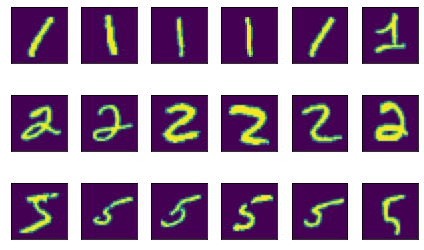

In [ ]:
fig, axs = plt.subplots(3,6)
for i in range(6):
  axs[0,i].imshow(ones[i])
  axs[0,i].set_xticks([])
  axs[0,i].set_yticks([])
  axs[1,i].imshow(twos[i])
  axs[1,i].set_xticks([])
  axs[1,i].set_yticks([])
  axs[2,i].imshow(fives[i])
  axs[2,i].set_xticks([])
  axs[2,i].set_yticks([])

plt.tight_layout()

## Echec des métriques de similarités entre images

On note une certaine variabilité entre les imagettes d'un même type de digit. Jusqu'à quel point ces imagettes sont similaires/différentes. Pour ce faire nous allons utiliser une métrique pour comparer la similarité entre 2 images.

In [ ]:
!pip install sewar

  Preparing metadata (setup.py) ... done
  Created wheel for sewar: filename=sewar-0.4.5-py3-none-any.whl size=10583 sha256=c9e8337cd299e711157a3f3ce4f8f1b322e9237c6e3a9637135d5fcda3586179
  Stored in directory: /pbs/home/c/campagne/.cache/pip/wheels/d5/46/c1/7d4cdb3e32c09f3186ed699b12ac8aef0152932ab72f8fc9a5
Successfully built sewar


In [ ]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp

Dans la suite nous allons utiliser la MSE: Mean Squared Error mais on peut utiliser une autre. Mettons que l'on dispose d'une image $I$ et d'une image de référence $R$, toutes les deux ayant $N_{pix}$ pixels, alors la $MSE$ entre ces 2 images est calculée selon 

$$
MSE(I,R) = \frac{1}{N_{pix}} \sum_{i=1}^{N_{pix}} (I(i)- R(i))^2
$$

Prenons par la suite comme référence la première image de la collection des $5$. 

In [ ]:
ref = fives[0]

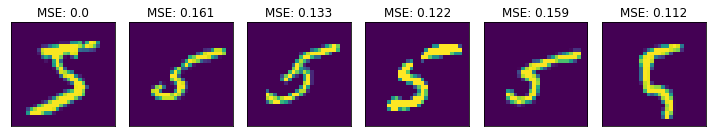

In [ ]:
# MSE de quelques "5" avec comme référence le premier
fig, axs = plt.subplots(1,6,figsize=(10,5))
for i in range(6):
  axs[i].imshow(fives[i])
  axs[i].set_xticks([])
  axs[i].set_yticks([])
  axs[i].set_title(f"MSE: {mse(fives[i],ref):.3}")
plt.tight_layout()

Comparons sur quelques images de différents types de digits la variablité de la MSE (toujours la même image de référence)

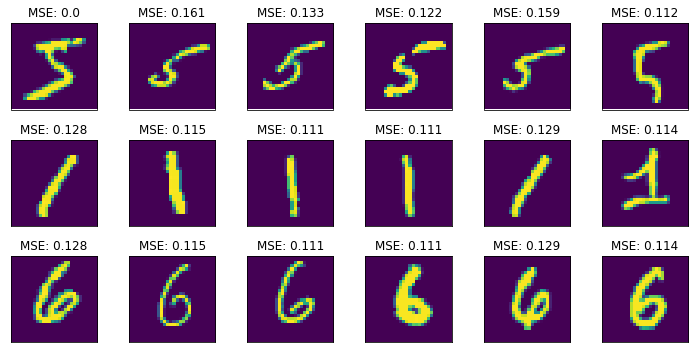

In [ ]:
fig, axs = plt.subplots(3,6,figsize=(10,5))
for i in range(6):
  axs[0,i].imshow(fives[i])
  axs[0,i].set_xticks([])
  axs[0,i].set_yticks([])
  axs[0,i].set_title(f"MSE: {mse(fives[i],ref):.3}")
  axs[1,i].imshow(ones[i])
  axs[1,i].set_xticks([])
  axs[1,i].set_yticks([])
  axs[1,i].set_title(f"MSE: {mse(ones[i],ref):.3}")
  axs[2,i].imshow(sixs[i])
  axs[2,i].set_xticks([])
  axs[2,i].set_yticks([])
  axs[2,i].set_title(f"MSE: {mse(ones[i],ref):.3}")

plt.tight_layout()

La variabilité de la MSE semble similaire sans distinction entre type de digits. Tentons de confirmer cette impression avec toutes les imagettes de training. 

In [ ]:
# definissons le "score" comme le resultat de la similarité entre l'image courante "I" et la reference "R".
def get_score(imgs, ref=fives[0], func=mse):
  score=np.zeros(len(imgs))
  for i,img in enumerate(imgs):
      score[i] = func(imgs[i],ref)
  return score

Obtenons le "score" de similarité (MSE par défaut) pour toutes les catégories de digits par rapport à la même référence.

In [ ]:
score0 = get_score(zeros)
score1 = get_score(ones)
score2 = get_score(twos)
score3 = get_score(threes)
score4 = get_score(fours)
score5 = get_score(fives)
score6 = get_score(sixs)
score7 = get_score(sevens)
score8 = get_score(heights)
score9 = get_score(nines)

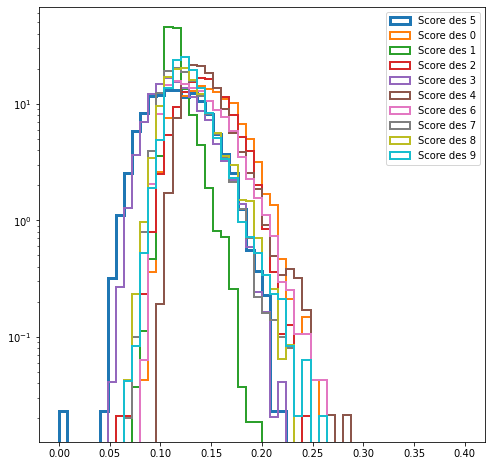

In [ ]:
plt.figure(figsize=(8,8))
_,bins,_=plt.hist(score5,bins=50,density=True, range=(0,0.4), linewidth=3, histtype="step", label="Score des 5")
plt.hist(score0,bins=bins,density=True,  linewidth=2, histtype="step", label="Score des 0");
plt.hist(score1,bins=bins,density=True,  linewidth=2, histtype="step", label="Score des 1");
plt.hist(score2,bins=bins,density=True,  linewidth=2, histtype="step", label="Score des 2");
plt.hist(score3,bins=bins,density=True,  linewidth=2,histtype="step", label="Score des 3");
plt.hist(score4,bins=bins,density=True,  linewidth=2,histtype="step", label="Score des 4");
plt.hist(score6,bins=bins,density=True,  linewidth=2,histtype="step", label="Score des 6");
plt.hist(score7,bins=bins,density=True,  linewidth=2,histtype="step", label="Score des 7");
plt.hist(score8,bins=bins,density=True,  linewidth=2,histtype="step", label="Score des 8");
plt.hist(score9,bins=bins,density=True,  linewidth=2,histtype="step", label="Score des 9");
plt.yscale("log")
plt.legend();

On constate que la variabilité du score (MSE) ne change pas vraiment si l'on prend tel ou tel type de digit. Comme, le montre les 2 calculs suivants, les valeurs de la MSE sont plus petites que si on comparait le "5" de référence avec un image de bruit aléatoire, donc cela nous dit que les imagettes de digits sont structurées, mais si la valeur de MSE=0.15 est quasi identique à celle obtenue quand on compare deux images aléatoires. Ainsi, que cela soit les "5" entres-eux (courbe bleue foncé) ou bien les autres digits vis-à-vis du 5 de références, tout porte à croire que les images se comportent comme des objets aléatoires sans similarité. Tout du moins les métriques de type MSE que l'on aurait pu utiliser pour apprecier si deux courbes/surfaces sont "proches" l'une de l'autre, ne fonctionne pas pour classer 
des images.   

In [ ]:
# MSE I=image random, R: "5"
x=np.random.uniform(size=(784,)).reshape(28,28)
mse(x,ref)

0.3128797116447471

In [ ]:
# MSE I et R sont 2 images random
x=np.random.uniform(size=(784,)).reshape(28,28)
y=np.random.uniform(size=(784,)).reshape(28,28)
mse(x,y)

0.159387629775051

## A-ton plus de chance avec les moments des images? Oui mais...

Utiliser une métrique de type MSE à montrer quelle ne peut distinguer des digits tels que des 5 par rapport aux autres types de digits. Par contre, on sent bien visuellement que l'on peut les distinguer. Alors, on peut se demander les images de "5" et autres digits ne pourraient pas être caractérisées par des nombres représentant leurs morphologies. Dans ce cadre, **les moments** d'une image sont à exploiter. 

L'expression du moment d'ordre $(p,q)$ d'une image $I$ de $n_w \times n_h$ pixels s'exprime selon
$$
M_{p,q} = \sum_{i}^{n_w}\sum_{j}^{n_h} i^p j^q I(i,j)
$$ 
Comme le même digit peut être écrit à des positions légérement différentes, il convient de s'affranchir de cette **invariance**, en considérant les **moments centrés**. Dans ce cas il faut remplacer:
$$
\begin{array}{rcl}
i &\rightarrow & i - M(1,0)/M(0,0) \\
j &\rightarrow & j - M(0,1)/M(0,0)
\end{array}
$$  
On normalise les moments en divisant $M(p,q)$ par $M(0,0)$.

Par la suite on n'utilise que les moments centrés jusqu'à l'ordre $3$ ($p+q\leq 3$). Par définition, $M^c(1,0)=M^c(0,1)=0$, ils ne rentrent donc pas dans la liste. De plus $M(0,0)$ représentant l'intensité globale de l'image, elle n'est pas pertinante car un même digit pourrait être écrit avec différente finesse de stylo qui donnerait alors différentes valeurs de $M(0,0)$. C'est une autre **invariance** dont il faut s'affranchir, et c'est la raison pour laquelle on utilise des moments centrés **normalisés**.

Il est remarquable que la matrice constituée par 
$$
\Sigma = \begin{pmatrix}
M^c(2,0) & M^c(1,1) \\
M^c(1,1) & M^c(0,2)
\end{pmatrix}
$$
est la matrice de covariance empirique de la distribution des pixels de l'image. Si on avait affaire à une répartition gaussienne des valeurs de $I(i,j)$ répartie sur l'imagette, alors $\Sigma$ serait une approximation de la matrice de covariance de la distribution gaussienne. Les moments centrés normalisés d'ordre 3.

Enfin, pour s'affranchir de l'**invariance par petites rotations** qui viendraient changer l'orientation d'une image sans en changer la sémantique (c'est-à-dire que l'on reconnait toujours le digit concerné) alors on utilise les moments de Ming-Kuei Hu (1962) [(voir ici)](http://www.sci.utah.edu/~gerig/CS7960-S2010/handouts/Hu.pdf).




In [ ]:
def raw_moment(data, iord, jord):
    nrows, ncols = data.shape
    y, x = np.mgrid[:nrows, :ncols]
    data = data * x**iord * y**jord
    return data.sum()

In [ ]:
# moments centres et invariants par rotation d'une image jusqu'a l'ordre 3 (n+m<=3) 
def mom(img, rot_inv=True):
    img_sum = img.sum()
    M10 = raw_moment(img, 1, 0)
    M01 = raw_moment(img, 0, 1)
    x_bar = M10 / img_sum
    y_bar = M01 / img_sum

    M11 = raw_moment(img, 1, 1)
    M20 = raw_moment(img, 2, 0)
    M02 = raw_moment(img, 0, 2)

    mu11 = (M11 - x_bar * M01) / img_sum
    mu20 = (M20 - x_bar * M10) / img_sum
    mu02 = (M02 - y_bar * M01) / img_sum

    M21 = raw_moment(img, 2, 1)
    M12 = raw_moment(img, 1, 2)
    M30 = raw_moment(img, 3, 0)
    M03 = raw_moment(img, 0, 3)

    mu21 = ( M21 \
            -2*x_bar* M11 - y_bar* M20 + 2*x_bar*x_bar * M01) / img_sum
    mu12 = (M12 \
            -2*y_bar* M11 - x_bar* M02 + 2*y_bar*y_bar * M10) / img_sum
    mu30 = (M30 \
      -3*x_bar*M20 + 2*x_bar*x_bar* M10)  / img_sum
    mu03 = ( M03 \
      -3*y_bar*M02 + 2*y_bar*y_bar * M01)  / img_sum
    # covariance mtx = [[m20,m11],[m11,m02]]

    if rot_inv :
      I1 = mu20 + mu02
      I2 = (mu20-mu02)**2 + 4*mu11**2
      I3 = (mu30-3*mu12)**2 + (3*mu21 - mu03)**2
      I4 = (mu30+mu12)**2 + (mu21+mu03)**2
      I5 = (mu30-3*mu12)*(mu30+mu12)*((mu30+mu12)**2-3*(mu21+mu03)**2) +\
          (3*mu21-mu03)*(mu21+mu03)*(3*(mu30+mu12)**2-(mu21+mu03)**2)
      I6 = (mu20-mu02)*((mu30+mu12)**2-(mu21+mu03)**2)+\
            4*mu11*(mu30+mu12)*(mu21+mu03)
      I7 = (3*mu21-mu03)*(mu30+mu12)*((mu30+mu12)**2-3*(mu21+mu03)**2) -\
            (mu30-3*mu12)*(mu21+mu03)*(3*(mu30+mu12)**2-(mu21+mu03)**2)
    else:
      I1,I2,I3,I4,I5,I6,I7 = mu20,mu11,mu02,mu21,mu12,mu30,mu03

    return np.array([I1,I2,I3,I4,I5,I6,I7])



Essayons sur un exemple, l'invariance des moments calculés. D'abord translation: 

In [ ]:
data = fives[0]

In [ ]:
data_cpy = data.copy()
data1 = np.roll(data_cpy, 2, axis=0)
data2 = np.roll(data_cpy, 2, axis=1)

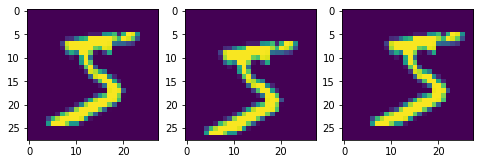

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,10))
ax[0].imshow(data)
ax[1].imshow(data1)
ax[2].imshow(data2)

In [ ]:
mom(data), mom(data1), mom(data2)

(array([ 5.86681463e+01,  1.09637075e+03,  1.20192919e+04,  2.68575499e+03,
         5.52563792e+06,  2.51848892e+04, -1.42238637e+07]),
 array([ 5.86681463e+01,  1.09637075e+03,  1.20192919e+04,  2.68575499e+03,
         5.52563792e+06,  2.51848892e+04, -1.42238637e+07]),
 array([ 5.86681463e+01,  1.09637075e+03,  1.20192919e+04,  2.68575499e+03,
         5.52563792e+06,  2.51848892e+04, -1.42238637e+07]))

puis la rotation

In [ ]:
! pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 25.6 MB/s eta 0:00:0000:0100:01


In [ ]:
! pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25836 sha256=1f3d4a6dbb64ca5ff156c2961e10185b4bf57ab474d4b600bbee44982a3d393b
  Stored in directory: /pbs/home/c/campagne/.cache/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils


In [ ]:
import cv2
import imutils


In [ ]:
rot1 = imutils.rotate(data, angle=20)

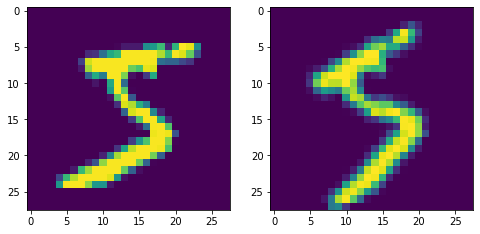

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,10))
ax[0].imshow(data)
ax[1].imshow(rot1)

In [ ]:
mom(data), mom(rot1)

(array([ 5.86681463e+01,  1.09637075e+03,  1.20192919e+04,  2.68575499e+03,
         5.52563792e+06,  2.51848892e+04, -1.42238637e+07]),
 array([ 5.89589873e+01,  1.09511843e+03,  1.21013263e+04,  2.67710086e+03,
         5.54937862e+06,  2.53759882e+04, -1.41910416e+07]))

Préparons le calcul des moments des différentes imagettes des collections de digits.

In [ ]:
def get_moms(imgs):
  infos = np.zeros((len(imgs),7))
  for i,img in enumerate(imgs):
    infos[i] = mom(img)
  return infos

In [ ]:
infos_0 = get_moms(zeros)
infos_1 = get_moms(ones)
infos_2 = get_moms(twos)
infos_3 = get_moms(threes)
infos_4 = get_moms(fours)
infos_5 = get_moms(fives)
infos_6 = get_moms(sixs)
infos_7 = get_moms(sevens)
infos_8 = get_moms(heights)
infos_9 = get_moms(nines)









In [ ]:
infos_5.shape

(5421, 7)

In [ ]:
infos_all = np.vstack((infos_0, infos_1, infos_2, infos_3, infos_4, infos_5,\
                       infos_6, infos_7, infos_8, infos_9))

In [ ]:
infos_all.shape

(60000, 7)

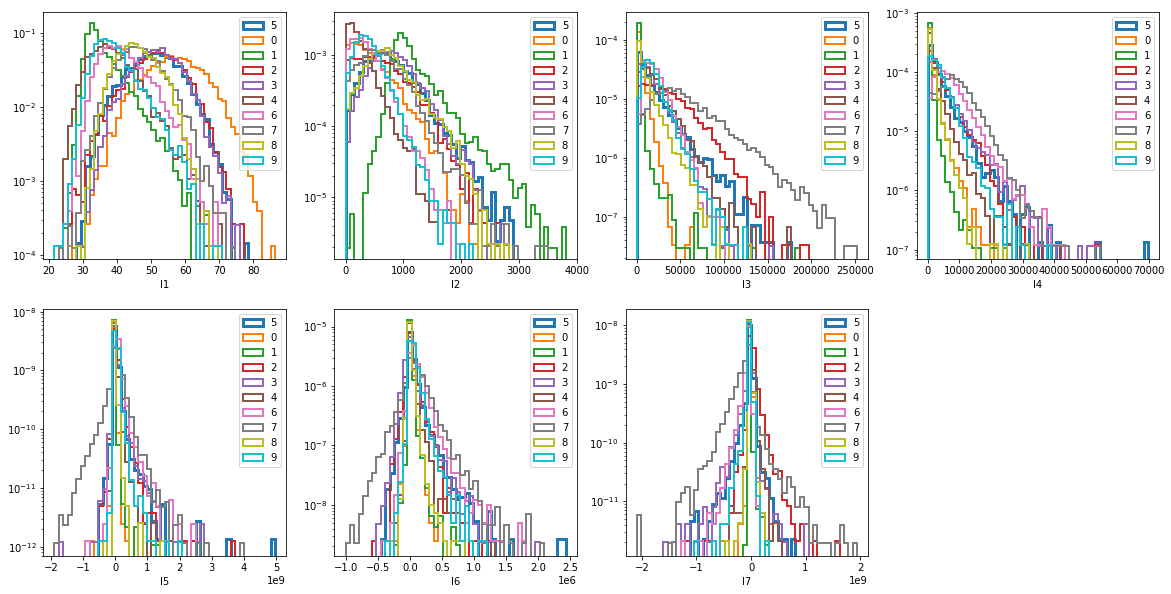

In [ ]:
fig,axs = plt.subplots(nrows=2,ncols=4, figsize=(20,10))
names = ["I1","I2","I3","I4","I5","I6","I7"]
idx = 0
for i in range(3):
  for j in range(4):
      if idx>=7:
        break
      x_min = infos_all[:,idx].min()
      x_max = infos_all[:,idx].max()
      _,bins,_ = axs[i,j].hist(infos_5[:,idx],bins=50,density=True, range=(x_min, x_max), linewidth=3, histtype="step", label="5")
      axs[i,j].hist(infos_0[:,idx],bins=bins,density=True,  linewidth=2, histtype="step", label="0");
      axs[i,j].hist(infos_1[:,idx],bins=bins,density=True,  linewidth=2, histtype="step", label="1");
      axs[i,j].hist(infos_2[:,idx],bins=bins,density=True,  linewidth=2, histtype="step", label="2");
      axs[i,j].hist(infos_3[:,idx],bins=bins,density=True,  linewidth=2,histtype="step", label="3");
      axs[i,j].hist(infos_4[:,idx],bins=bins,density=True,  linewidth=2,histtype="step", label="4");
      axs[i,j].hist(infos_6[:,idx],bins=bins,density=True,  linewidth=2,histtype="step", label="6");
      axs[i,j].hist(infos_7[:,idx],bins=bins,density=True,  linewidth=2,histtype="step", label="7");
      axs[i,j].hist(infos_8[:,idx],bins=bins,density=True,  linewidth=2,histtype="step", label="8");
      axs[i,j].hist(infos_9[:,idx],bins=bins,density=True,  linewidth=2,histtype="step", label="9");
      axs[i,j].set_xlabel(names[idx])
      axs[i,j].set_yscale("log")
      axs[i,j].legend()

      idx += 1
fig.delaxes(axs[1,3])

In [ ]:
def f(x):
  return 2500*(x-27)/(60-27)

In [ ]:
x_vals = np.linspace(30,80)
y_vals = f(x_vals)

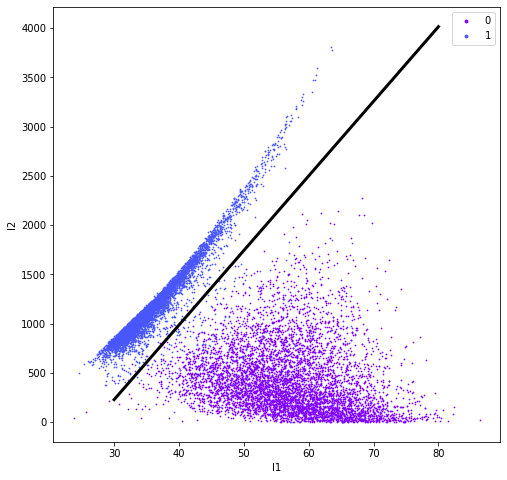

In [ ]:
fig = plt.figure(figsize=(8,8))
color = iter(mpl.cm.rainbow(np.linspace(0, 1, 10)))
for digit_idx, digit_mom  in enumerate([infos_0, infos_1]):
                       
  c = next(color)
  plt.scatter(digit_mom[:,0],digit_mom[:,1],color=c,s=0.5,label=f'{digit_idx}')

plt.plot(x_vals,y_vals,c="k",lw=3)


plt.xlabel(names[0])
plt.ylabel(names[1])
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legendHandles:
    handle.set_sizes([8.0])


In [ ]:
def clf(Imom):
  I1, I2 = Imom[0], Imom[1]
  if f(I1)>I2:
     return 0
  else:
    return 1  

Pour séparer les "0" et les "1", les moments "I1" et "I2" ont l'air très bien adaptés pour une copure en 2D. Voyons ce que cela donne avec un classificateur purement linéaire (ligne noire).

In [ ]:
pred_0=np.array([-1]*len(infos_0))
for i,Imom in enumerate(infos_0):
    pred_0[i] = clf(Imom)
    

pred_1=np.array([-1]*len(infos_1))
for i,Imom in enumerate(infos_1):
    pred_1[i] = clf(Imom)

In [ ]:
print(f"Accuracy (%) à reconnnaitre les 0 (train) = {np.mean(pred_0==0)*100:.2f} ")
print(f"Accuracy (%) à reconnnaitre les 1 (train) = {np.mean(pred_1==1)*100:.2f} ")

Accuracy (%) à reconnnaitre les 0 (train) = 99.70 
Accuracy (%) à reconnnaitre les 1 (train) = 97.89 


Pour les lots de training, on atteind presque la perfection! Qu'en est-il pour les 0 et 1 du lot de test? Par cela on teste la généralisation du classificateur.

In [ ]:
zeros_test = x_test[y_test==0].squeeze()
ones_test = x_test[y_test==1].squeeze()
infos_0_test = get_moms(zeros_test)
infos_1_test = get_moms(ones_test)

pred_0=np.array([-1]*len(infos_0_test))
for i,Imom in enumerate(infos_0_test):
    pred_0[i] = clf(Imom)
    

pred_1=np.array([-1]*len(infos_1_test))
for i,Imom in enumerate(infos_1_test):
    pred_1[i] = clf(Imom)

print(f"Accuracy (%) à reconnnaitre les 0 (test) = {np.mean(pred_0==0)*100:.2f} ")
print(f"Accuracy (%) à reconnnaitre les 1 (test) = {np.mean(pred_1==1)*100:.2f} ")

Accuracy (%) à reconnnaitre les 0 (test) = 99.90 
Accuracy (%) à reconnnaitre les 1 (test) = 98.41 


Résultats parfaits! la généralisation se passe parfaitement bien et donc on obtient des taux d'erreur de reconnaissance des 0 et des 1 de 0.1% et 1.6% respectivement. Mais cela est obtenu si seuls les 0 et les 1 sont les 2 classes à séparer. Qu'en est-il si on mélange tous les types de digits?

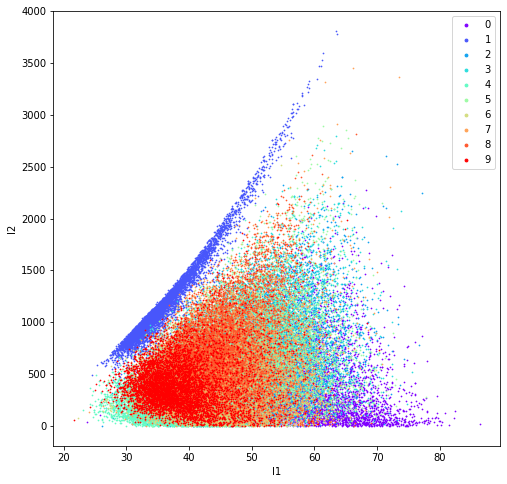

In [ ]:
fig = plt.figure(figsize=(8,8))
color = iter(mpl.cm.rainbow(np.linspace(0, 1, 10)))
for digit_idx, digit_mom  in enumerate([infos_0, infos_1, infos_2, infos_3, infos_4, infos_5,infos_6, infos_7, infos_8, infos_9]):
                       
  c = next(color)
  plt.scatter(digit_mom[:,0],digit_mom[:,1],color=c,s=0.5,label=f'{digit_idx}')

plt.xlabel(names[0])
plt.ylabel(names[1])
lgnd = plt.legend(loc="upper right", scatterpoints=1, fontsize=10)
for handle in lgnd.legendHandles:
    handle.set_sizes([8.0])


Humm... si les "1" pourraient être séparés des autres digits, on voit un mélange dès lors que l'on aimeraient séparer les autres digits entres-eux. Ceci dit on ne se sert ici que des moments "I1" et "I2". Nous allons voir ce qu'il advient si on utilise tous les moments (I1,...,I7). 

Pour cela il nous faut à partir de x_train (cf. les affichettes 27x27) calculer les 7 moments. 

In [ ]:
x_train.shape

(60000, 1, 28, 28)

In [ ]:
len(x_train)

60000

In [ ]:
x_train[0].shape

(1, 28, 28)

In [ ]:
new_x_train = np.zeros((len(x_train),7))
for idx,x in enumerate(x_train):
    new_x_train[idx] = mom(x.squeeze())

In [ ]:
new_x_train.shape, y_train.shape

((60000, 7), (60000,))

In [ ]:
new_x_test = np.zeros((len(x_test),7))
for idx,x in enumerate(x_test):
    new_x_test[idx] = mom(x.squeeze())

Pour classer les digits, ont va utiliser une méthode qui généalise l'usage d'une coupe dans le plan (I1,i2) qui a servit à discerner les "0" et les "1". Ici, on se place dans l'espace de dimension 7 des *features* qui sont les 7 moments $(I_i)_{i\leq 7}$, et on utilise des arbres de décisions binairent qui optimisent les coupures afin qu'aux feuilles terminales on obtienne 1 feuille par classe de digit.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(random_state=0)

In [ ]:
# entrainons le classificateur sur les données de "training"
clf.fit(new_x_train, y_train)

RandomForestClassifier(random_state=0)

Après entrainement, on peut prédire à parir des 7 moments d'une imagette, à quel digit elle correspond. Puis on peut comparer cette prédiction, à la valeur "vraie" du label (cf. à quelle classe de digit cette imagette a-t'elle était étiquetée). On en tire alors la moyenne de la performance (dite "accuracy") à la fois sur le lot de training (1) et sur le lot de test (2). On répond alors à deux questions:
1.   est-ce que le classificateur est suffisament "puissant" pour rendre compte des diversités de classes de digit ? 
2.   est-il capable de généralisation?

Si les deux questions sont importantes, la seconde revet un caractère pratique essentiel, car à quoi bon être entrainer à reconnaitre des digits déjà étiquetés, si on est pas capable de reconnaitre le digit sur une nouvelle imagette.

Comment se comporte notre classificateur?




In [ ]:
pred_test = clf.predict(new_x_test)
perf_test = pred_test == y_test

pred_train = clf.predict(new_x_train)
perf_train = pred_train == y_train


In [ ]:
print(f"Accuracy (Training) en % = {np.mean(perf_train)*100:.2f}")
print(f"Accuracy (General.) en % = {np.mean(perf_test)*100:.2f}")

Accuracy (Training) en % = 100.00
Accuracy (General.) en % = 66.45


Intéressant pour un premier résultat! Le classificateur s'en est sorti pour  apprendre parfaitement (100% accuracy sur le lot de training), et obtient un score de reconnaissance de nouveaux digits de 66.5% soit un taux d'erreur de 33.5%. La baisse  de score entre le lot de training et le lot de test signe ce qui est appelé de **l'overfitting**.  

Avant de passer aux réseaux de neurones, voyons 2 choses à propos de ce classificateur:


1.   Quelle est l'importance relative de chaque moment $I_i$ pour réaliser la classification?
2.   Est-ce que tous les types de digits sont également bien/mal classés?





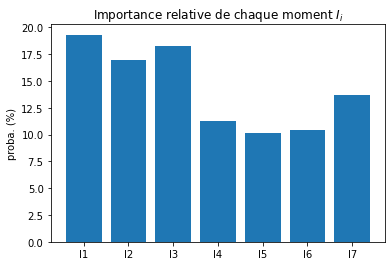

In [ ]:
names = ["I1","I2","I3","I4","I5","I6","I7"]
plt.bar(names,  clf.feature_importances_*100)#, bar_width, bottom=y_offset, align='center')
plt.ylabel("proba. (%)")
plt.title("Importance relative de chaque moment $I_i$");

Même si les 3 premiers moments sont plus importants que les autres, il semble bien qu'aucun moment peut être jugé comme inutile. Donc, le classificateur à utilisé toutes les ressources dont il disposait.

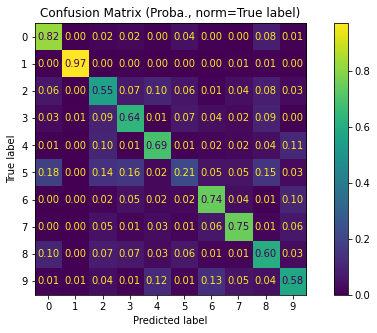

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

target_names = [str(i) for i in range(10)]
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred_test, ax=ax, 
                                        normalize="true", values_format=".2f")
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix (Proba., norm=True label)"
)

La matrice de confusion ci-dessus indique les probabilités qu'un digit de label vrai (True label) $\ell_{true}$ soit classé parmi les 10 digits. Par exemple les digits "0" sont reconnus comme tels à 82% et par exemple à 8% comme des "8". La diagonale de cette matrice indique les probabilités de reconnaitre correctement le digit en question. On remarque alors que les "1" sont reconnus à 97%, score le plus élevé ce qui confirme que les "1" sont "faciles" à reconnaitre,  ce nous avions intuités plus haut. Par contre, le "5" est le digit le plus difficile à reconnaitre (voir la ligne des "5" True label): ils sont souvent confondus avec des "0", "2", "3" et des "8".  

# Réseaux de Neurones.

On va s'intéresser maintenant à ce qu'un réseau de neuronnes peut nous apporter dans ce contexte de classification de digits. Si on pourrait envisager les moments $(I_i)_{i\leq7}$ comme *features*, on va directement s'intéresser aux images elles-mêmes.

Cependant, comme on l'a vu, l'idée de trouver une métrique qui mesure la différence entre 2 images ne parrait pas être un bon angle d'attaque. On va donc utiliser les labels des images. Mais il y a un problème qui se pose à nous. 

Si on note $X$ une image, c'est en quelque sorte un vecteur de $N_{pixels}=28^2=784$ valeurs dans $[0,1]$, on aimerait alors trouver une fonction $f$, telle que $f(X)=y$ où $y$ est le label (c-a-d le numéro du digit). Connaissant les images d'entrainement et leurs labels ${X_i,y_i}_{i\leq N_{train}}$, on veut alors déterminer les paramètres $\theta$ de la fonction $f$, tels que $f_{\theta^\ast}$ soit le meilleur interpolateur sur le lot d'entrainement, et qui plus est, il doit être également un interpolateur du lot de test. Or, pour déterminer $\theta^\ast$, il nous faut une métrique $\ell$(fonction de coût ou ***loss function***) ***différentiable*** car on va envisager une méthode par *descente de gradient*
$$
\theta^{t} = \theta^{t-1} - \eta \langle \nabla_\theta \ell(\theta^{t-1})\rangle
$$
où la moyenne du gradient de $f$ peut être calculé sur un lot d'images training plus ou moins important (**Batch**).

## L'usage des Hot-vectors et cross-entropie
Mais pour définir $f$, on va non pas s'intéresser à $y$ proprement dit mais plutôt à la probabilité d'obtenir $y$ connaissant l'image $X$, c'est-à-dire
$$
p_\theta(y|X)
$$  
(notons que $\sum_y p_\theta(y|X) = 1$). Mais pour cela, il nous faut une façon de coder les labels $y$ selon une robabilité d'obtenir le digit en question parmis tous les autres digits. Pour ce faire on utilise les ***hot-vectors***. Par exemple, un "5" est codé selon
$$
(0., 0., 0., 0., 0., 1., 0., 0., 0., 0.) = (y(k))_{k\in \{0,\dots,K-1\}}
$$
En quelque sorte c'est une distribution $\delta$ discrète: $y(k)=\delta(k-5)$ dans le cas ci-dessus.

Ainsi, 

  1. pour déterminer $\tilde{y}$ (ou plutôt $k$ si on pense aux hot-vectors) à partir d'une image $X$ on utilise le principe du **maximum de vraisemblance**:
$$
\tilde{k} = \underset{k\in \{0,\dots,K-1\}}{\mathrm{argmax}}\ p_{\theta^\ast}(k|X)
$$

  2. pour déterminer $\theta^\ast$, on utilise ***l'entropie croisée*** (voir Th. de Shannon de 1948) entre la distribution en sortie de réseau $p_{\theta}(k|X)$ et la vraie distribution $y(k)$: 
\begin{align}
\ell_{(y(k),X)}(\theta) &= E_{k\sim y(k)}[-\log p_{\theta}(k|X)] = -\sum_{k^\prime=0}^K y(k^\prime) \log p_{\theta}(k^\prime|X)\\ 
&= - \log p_{\theta}(k|X)
\end{align}
et si l'on considère le lot d'entrainement, on peut opérer une moyenne pour que $\theta^\ast$ permette une classification sur l'ensemble du lot 
$$
\theta^\ast = \underset{\theta}{\mathrm{argmin}}\ \langle  \ell_{(y(k),X)}(\theta) \rangle_{(y(k),X) \in Train}
$$

L'entropie croisée est intimement reliée à la  ***divergence Kullback-Leibler***  qui mesure la "distance" entre 2 distributions de probabilité  : 
$$
 D_{KL}(p||q) = E_p[\log (p/q)] = E_{x\sim p(x)}[\log p(x)] -E_{x\sim p(x)}[\log q(x)]
$$
(ce n'est pas vraiment une distance, mais il n'en reste pas moins vrai que si $D_{KL}(p||q)=0$ alors les 2 distributions $p$ et $q$ sont identiques).
Si $q$ dépend de paramètre $\theta$ alors minimiser l'entropie croisée (second terme) revient à minimiser la divergence Kullback-Leibler, et vice-versa.

## La fonction softmax

Dans ce schéma, il nous faut préciser comment obtenir $p_\theta(k|X)$? Dans l'image ci-dessous, on a représenté de façon simplifiée les processus de transformations du vecteur d'entrée $X$ à travers les différentes couches du réseau jusqu'à la sortie $y$.

![MLP avec Softmax](https://drive.google.com/uc?id=1AmXfWVsejltzQdwo1lNH63_b1ePLSSOA) 

Chaque couche est constituée par des neurones dont la valeur de sortie est conditionnée par les entrées qui lui sont affectées (flèches entrantes), les poids de chaque entrée, l'ajout éventuel d'une constante (biais) et l'application d'une non-linéarité.  Chaque neurone est un petit module construit à partir d'un Perceptron inventé par Frank Rosenblatt en 1957 illustré sur la figure suivante. C'est un *classificateur linéaire* auquel on lui adjoint une non-linéairité (fonction sigmoïde, tanh, rectificateur linéaire, etc).  

![Perceptron](https://drive.google.com/uc?id=1JiPDdz1TrMLA_4Y8Wyz-GQgR7ELaFUlJ)

La dernière couche (sortie) notée $(x_J(k))_{k<K}$ (où $J$ indique l'indice de la dernière couche) est un vecteur de dimension égale au nombre de labels (classes) des digits, donc $K=10$ neurones (on en a représenté que 4 par soucis de simplicité tout comme pour l'entrée au lieu des 3 éléments, il faut comprendre 28x28=784 éléments pour les imagettes de MNIST). Mais ces valeurs de sortie $(x_J(k))$ ne sont en aucun cas des probabilités ni même des valeurs positives, c'est pour cela que l'on utilise la fonction ***softmax*** qui transforme $z_y$ selon
$$
softmax(x_J(k)) = \frac{e^{x_J(k)}}{\sum_{k^\prime=0}^{K-1} e^{x_J(k^\prime)}}= p(k) 
$$
*Remarquons on passage qu'en Mécanique Statistique, la probabilité dans l'ensemble canonique quantique est essentiellement une fonction softmax appliquée à $-\beta E_c$ (où $E_c$ est l'énergie du système dans la configuration $c$, et $\beta=1/kT$).*

Comme le résultat $p(k)$ dépend de l'entrée $X$ et des paramètres du réseau via $x_J(k)$, on note naturellement le résulat $p_\theta(k|X)$. C'est donc cette probabilité qu'il faut confronter à la distribution (vraie) $y(k)$ à l'aide l'entropie croisée.

Comme on l'a vu plus haut


\begin{align}
\ell_{(y(k),X)}(\theta) &= -\log p_\theta(k|X) = -\log(softmax(x_J(k))) \\
&= - x_J(k) + \log \left(\sum_{k^\prime=0}^{K-1} e^{x_J(k^\prime)} \right) 
\end{align}

Imaginons un instant que parmi les $x_J(k^\prime)$ il y ait un maximum se détachant des autres valeurs, alors
$$
\log\sum_{k^\prime} e^{x_J(k^\prime)} \approx \max_{k^\prime}[x_J(k^\prime)]
$$
et donc
$$
\ell_{(y(k),X)}(\theta) \approx -x_J(k) + \max_{k^\prime}[x_J(k^\prime)]
$$
Ce qui revient à comparer alors $x_J(k)$ et $\max_{k^\prime}[x_J(k^\prime)]$. Si lors d'une étape d'optimisation des poids $\theta$ du réseau, $\max_{k^\prime}[x_J(k^\prime)]$ est obtenu pour $k^\prime=k$ alors on a gagné  car la différence vaut $0$ et $p_\theta(k|X)=1$.

Outre le fait que le softmax permet de faire ressortir un maximum qui se détache via l'exponentielle, c'est une **opération différentiable** ce que nous recherchions pour la descente de gradient afin d'obtenir $\theta^\ast$. 

Bien entendu $x_J$ est fonction des paramètres du réseau, et on peut considérer que la loss est un enchainement de fonctions imbriquées. Pour calculer le gradient par rapport à un paramètre particulier, on procéde au calcul des dérivées composées (***chain rule***). Ainsi, une étape intermédiaire est de calculer le vecteur gradient $\partial_{x_J} \ell$. Ce qui donne alors simplement $\forall q < K$
$$
\frac{\partial \ell}{\partial x_J(q)} = -\delta(q-k) + softmax(x_J(q))
$$
On se rend compte que $\delta(q-k)$ n'est autre que la distribution $y(k)$, donc
$$
\partial_{x_J} \ell = softmax(x_J)-y
$$
L'usage du softmax rend le calcul du gradient aisé. L'opération ***softmax*** a  donc beaucoup d'avantages et c'est la panacée pour les réseaux ayant une tâche de classification.

Le code qui suit est une implentation de ce schéma avec la librairie JAX qui permet le calcul de différentiation automatique. On aurait pu utilser tout aussi bien, Pytorch ou TensorFlow, et des librairies dérivées.



In [4]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k """
    return jnp.array(x[:, None] == jnp.arange(k), dtype)


In [5]:
train_images = jnp.array(x_train, dtype=jnp.float32)
test_images  = jnp.array(x_test, dtype=jnp.float32)

In [6]:
N_train,c,h,w = train_images.shape
N_test = len(test_images)
num_pixels = h * w * c
num_labels = len(np.unique(y_train))

In [7]:
train_labels = one_hot(y_train, num_labels)
test_labels  = one_hot(y_test, num_labels)

In [8]:
train_labels[0], y_train[0]

(DeviceArray([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32), 5)

On définit un flux de données en découpant le lot de 60,000 imagettes de training en batch de 128 imagettes, de plus on visitera à chaque étape de la descente de gradient les batchs dans un ordre aléatoire. 

In [9]:
# decoupage du lot de training en batch de 128 imagettes
batch_size = 100
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

In [10]:
# randomize les batchs 
def data_stream():
  """Creates a data stream with a predifined batch size.
  """
  rng = np.random.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size: (i + 1)*batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]



In [11]:
# Un exemple pour obtenir un lot (batch) de 100 imagettes (training)
batches = data_stream()
x, y = next(batches) 
x.shape

(100, 1, 28, 28)

Pour apprécier si un modèle à de bonnes performances, nous allons généraliser ce que nous avons fait précédemment en comparant le label "vrai" associé à une imagette et le label prédit par le réseau.

In [12]:
def accuracy(params, batch, model):
  """ Calculates the accuracy in a batch.

  Args:
    params : Neural network parameters.
    batch : Batch consisting of images and labels.
    model: feed forward function of the network
  
  Outputs:
    (float) : Mean value of the accuracy.
  """

  # Unpack the input and targets
  inputs, targets = batch
  
  # Get the label of the one-hot encoded target
  target_class = jnp.argmax(targets, axis=1)
  
  # Predict the class of the batch of images using 
  # the model defined by its parameters
  predicted_class = jnp.argmax(model(params, inputs), axis=1)

  return jnp.mean(predicted_class == target_class)

IL nous faut le calcul de la cross-entropy

In [13]:
def loss(params, batch, model):
  """ Cross entropy loss.
  Args:
    params : Neural network parameters.
    batch : Batch consisting of images and labels.
    model: feed forward function of the network
  
  Outputs:
    (float) : Sum of the cross entropy loss over the batch.
  """
  # Unpack the input and targets
  images, targets = batch
  # precdict the class using the neural network
  preds = model(params, images)

  # - sum_{X in batch}(y*p_{param}(y|X))
  return -jnp.sum(preds * targets)

Afin de réaliser la descente de gradient pour minimiser la fonction *loss*, il nous faut instancier un minimizer, à savoir le type (ici Adam) et ses paramètres (ex. le step size, aka  learning rate)

In [14]:
from jax.example_libraries import optimizers

step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)


In [15]:
from jax import jit, value_and_grad
from functools import partial

@partial(jit, static_argnums=(4,))
def update(params, x, y, opt_state, model):
    """ Compute the gradient for a batch and update the parameters """
    
    # Take the gradient and evaluate the loss function
    value, grads = value_and_grad(loss)(params, (x, y), model)
    
    # Update the network using the gradient taken
    opt_state = opt_update(0, grads, opt_state)
    
    return get_params(opt_state), opt_state, value

In [16]:
from tqdm.notebook import tqdm

def process(model, init_fun, num_epochs=10):
  """
    Model Optimization.

    Args:
      model: the feedforward function of the model
      init_fun: the model parameter initialisation function
      num_epochs: number of epochs

    Outputs:
      train_loss: array of losses computed on Trining set after each epoch
      val_loss:   array of losses computed on Test/Validation set after each epoch 
      train_acc:  array of accuracies on training set
      test_acc:  array of accuracies on test set
      params: model parameters after optimization
  """

  # initialisation of model parameters
  key = random.PRNGKey(0)
  _, params = init_fun(key, (-1,) + train_images.shape[1:]) # for varying batch size we put a -1 in first position

  #initialisation of optimizer
  opt_state = opt_init(params)

  #initialisation of training data_stream
  batches = data_stream()

  train_acc, test_acc = [], []
  train_loss, val_loss = [], []

  # loop over the different epochs
  for epoch in tqdm(range(num_epochs)):
    #loop over all batches 
    for _ in range(num_batches):
      # get a new batch: images (x) and labels (y)
      x, y = next(batches)    
      # 1-step gradient descent parameter optimization
      params, opt_state, _loss = update(params, x, y, opt_state, model=model)
      

    # Update parameters of the Network
    params = get_params(opt_state)

    # Compute loss (ie. cross-entropie) for both training set and test set (aka validation set) 
    train_loss.append(np.mean(loss(params, (train_images, train_labels), model=model))/len(train_images))
    val_loss.append(loss(params, (test_images, test_labels), model=model)/len(test_images))

    # Compute accuracy of the model both for training set and test set
    train_acc_epoch = accuracy(params, (train_images, train_labels), model=model)
    test_acc_epoch = accuracy(params, (test_images, test_labels), model=model)
    
    train_acc.append(train_acc_epoch)
    test_acc.append(test_acc_epoch)

  return train_loss, val_loss, train_acc, test_acc, params

In [17]:
def plot(num_epochs, train_loss, val_loss, train_acc, test_acc, 
         model_name="my_net"):
  epochs = range(num_epochs)

  fig = plt.figure(figsize=(12,6))
  gs = fig.add_gridspec(1, 2)
  ax1 = fig.add_subplot(gs[0, 0])
  ax2 = fig.add_subplot(gs[0, 1])

  ax1.plot(epochs, train_loss, 'r', label='Training')
  ax1.plot(epochs, val_loss, 'b', label='Validation')
  ax1.set_xlabel('Epochs', size=16)
  ax1.set_ylabel('Loss', size=16)
  ax1.legend()

  ax2.plot(epochs, train_acc, 'r', label='Training')
  ax2.plot(epochs, test_acc, 'b', label='Validation')
  ax2.set_xlabel('Epochs', size=16)
  ax2.set_ylabel('Accuracy', size=16)
  ax2.legend()
  ax2.grid()
  ax2.set_ylim([0.94, 1.0])
  plt.title(model_name)
  
  plt.show()

In [18]:
from jax.example_libraries import stax
from jax import random
from jax.example_libraries.stax import (Dense, Flatten, Relu, LogSoftmax)

Utilisons à présent, la librairie Stax de JAX pour construire le modèle de réseau.


Dans un premier temps on ne va utiliser que des **couches denses** (ou fully-connected) comme sur l'illustration donnée plus haut pour le  multi-layer perceptron. 

1.   La première couche/operation (Flatten) applati les images en 1 vecteur de 784 éléments 
2.   La seconde est de type **Dense**  où l'on spéecifie le nombre de neurones de sortie (120). Cette couche efefctue une opération matricielle
$$
out = W \times in + b
$$
La taille de $W$ est donc de $120 x 784$ éléments auxquels il faut rajouter 120 coefficients de biais ($b$).
3. La **non-linéarité Relu** qui intervient dans l'activation des neurones est une opération dite **element-wise** car elle s'applique à tous les éléments de sortie de la précédente couche. Son expression est la suivante
$$
Relu(x) = \begin{cases} x & x \geq 0 \\ 0 & x < 0 \end{cases}
$$  
c'est ce que l'on appelle un *rectificateur linéaire*. La justification théorique de ces non-linéarités va au-delà de ce notebook, cependant on peut se convaincre de la propriété suivante: si on enchaine que des couches denses les unes à la suite des autres, tout revient en fait à connecter l'entréé de la première, à la sortie de la seconde, par une couche dense et l'on abouti alors à un classificateur lineaire tout simple (cf. il ne fait que des coupes d'hyperplans) qui ne peut résoudre des problèmes à séparation non-linéaire comme le XOR ci-dessous

![XOR](https://drive.google.com/uc?id=1quXcYsKXl8v8NTwxWks6Qhwx2zaO9Hl6)

Donc, il est nécessaire de faire intervenir des non-linéarités telles que le ReLU, mais il y en a d'autres (Tanh, sigmoïde,...). 

4. On termine par une phase de mise à plat (Flatten), puis une couche Dense ayant 10 neurones de sortie (1 par digit). Par ce biais on réalise un classificateur linéaire à ce niveau. Puis on termine par l'opération Softmax ou plus préciséemnt on en calcule le log pour directement calculé cross-entropie.


Le nombre de paramètres définissant la fonction d'interpolation est  égal à (éléments des matrices + biais)
$$
\begin{array}{rccr}
Dense1 & 784\times 120+120 & =&94,200   \\
Dense2 & 120 \times 10 + 10 & =&1,210 \\
Total  & &  =& 95,410
\end{array}
$$
Les couches denses sont gourmandes en paramètres.

In [19]:
init_fun1, my_net1 = stax.serial(
    Flatten,
    Dense(120), Relu,
    Flatten,
    Dense(num_labels),
    LogSoftmax)

In [20]:
num_epochs=20
train_loss_1, val_loss_1, train_acc_1, test_acc_1, params_fit_1 = process(my_net1, init_fun1, num_epochs=num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

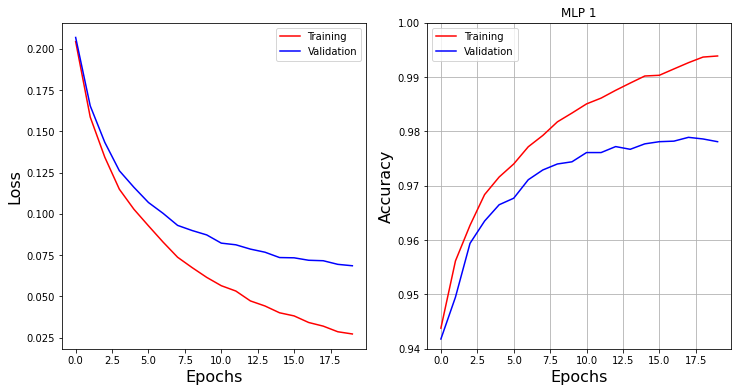

In [21]:
plot(num_epochs, train_loss_1, val_loss_1, train_acc_1, test_acc_1, 
         model_name="MLP 1")


In [ ]:
pred_test = jnp.argmax(my_net1(params_fit_1, test_images), axis=1)

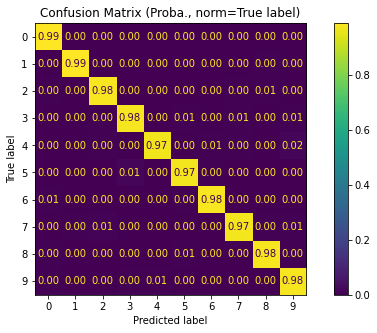

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
target_names = [str(i) for i in range(10)]
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred_test, ax=ax, 
                                        normalize="true", values_format=".2f")
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix (Proba., norm=True label)"
)

Incroyable n'est-il pas? On arrive à des taux d'erreur (Top 1) de près de 0.2% et des performances quasi-identiques pour tous les digits! On a donc réaliser un classificateur (non-linéaire) quasi-parfait pour résoudre le problème de la reconnaissance des digits écrits manuellement.


Ce type de réseaux dit à 1-couche cachée à fait l'objet d'études jusqu'à l'aboutissement de la démonstration du **Théorème d'Universalité** dans les années 1989-93. Cependant, ce théorème est qualifié de leurre car il stipule pour faire court que le ce type de réseau certes peut interpoler n'importe quelle fonction, cela se fait au prix d'un nombre de neurones $N$ de la couche cachée (120 dans le cas du MLP mis en oeuvre)  qui croit selon la loi d'échelle suivante:
$$
\Large N \sim ɛ^{-d/m}
$$
où $ɛ$ est l'erreur d'approximation, $d$ la dimension de l'entrée (pour MNIST $d=28\times 28 =784$ et $m$ est la classe de régularité de la fonction à interpoler. On voit se dessiner alors la **malédiction de la dimensionalité** car pour contrebalancer la grandeur de $d$ il faudrait ajuster uniquement des fonctions extrêmement régulaières (penser à $C^{784}$ !!! c'est quasiment des fonctions indéfiniment différentiables) or comment penser que classer des images se fait par une fonction régulière??? 

Ce théorème fut non pas un point final comme on aurait pu le penser, disposer d'un interpolateur universel aurait pu signer la fin de ce domaine, mais à plutôt le signe d'une faiblesse d'interprétation car par la suite l'avénement des réseaux convolutionnels à permis de s'attaquer à des problèmes très difficiles (reconnaissance d'images complexes, de la parole, traitement/analyse/génération de textes) avec des succés toujours aussi étonnants. 

Pour donner une idée de l'architecture d'un réseau couvolutionnel, je vais en mettre en oeuvre un tout simple pour classer les digits.

## Réseau convolutionnel

Une référence très éclairante sur les idées générales qui ont motivées Yann LeCun, Yoshua Bengio (et d'autres) à utliser les couches convolutionnelles (Conv) en lieu et place des couches denses, est la suivante: [Y. LeCun and Y. Bengio: Convolutional Networks for Images, Speech, and Time-Series, in Arbib, M. A. (Eds), The Handbook of Brain Theory and Neural Networks, MIT Press, 1995](http://yann.lecun.com/exdb/publis/pdf/lecun-bengio-95a.pdf)

Les arguments principaux sont les suivants:
    
1. coté paratique: Pour des problèmes plus complexes que MNIST, les couches denses deviennent problèmatiques comme la gestion de la mémoire
2. coté conceptuel: les couches denses ne prennent en aucun cas en compte la structuration des données (topologie) et leurs éventuelles invariances (translations, déformations locales)
    
En fait si les problèmes de type (1) peuvent être bloquants (à l'époque les pionniers ne disposaient pas encore de GPU!), ceux de type (2) sont le sujet de recherches en mathématiques tout comme d'autres sujets d'études liès à l'architecture des réseaux de neurones, à leur optimisation, et à leur théorèmes associés.

L'opération de convolution 2D est l'application d'un filtre 2D de taille ($k_H\times k_W$) en le faisant glisser sur l'ensemble d'une "image" de taille $H_{in} \times W_{in}$ comme sur la première figure ci-dessous. En principe $k_H, k_W$ sont bien plus petits que la taille des images $H, W$ et typiquement $k_H = k_W = 3$ ou $5$. Ici, il s'agit de filtres numériques discrétisés qui peuvent réaliser par exemple un smearing (via un filtre gaussien), une détection de transitions horizontales/verticales/obliques (via un opérateur laplacien)... 

Imaginons que le filtre détecte un type de contour, s'il y en a dans l'image il/ils sera/seront détecté(s) indépendament de la postion de l'objet dans l'image. C'est en ce sens que ***la convolution est adaptée à l'invariance par translation***. 

![Conv layer](https://drive.google.com/uc?id=1KF-CZl0pSuv14WlXkfoVGiRrs--7g5mg)

Les filtres étant de petites tailles, on peut en utiliser plusieurs afin d'obtenir une "cartographie" (**1 nouvelle image par filtre**)  par exemple de plusieurs orientations de transitions dans une image, le tout en une seule étape. Ainsi, si même on utilse une image en niveau de gris (ex. les imagettes MNIST que l'on a utilisées), on se retrouve avec cube de données de taille $H_{out} \times W_{out} \times C_{out}$ où $C_{out}$ sont les résultats de chaque filtre. Il s'agit des **canaux**. 

Cependant ces canaux ne sont pas indépendants. En efet, si de nouveau on applique une couche convolutionelle avec un filtre de dimension $K\times K$ alors le tenseur de sortie est relié au tenseur d'entrée par (les biais sont omis pour alléger)
\begin{equation}
\boxed{\phantom{A}
T^{out}_{i,j,k} = \sum_{c=1}^{C_{in}} \sum_{(u,v)\in \Delta_K} \mathcal{K}_{k,c,u+s,v+s} \times T^{in}_{i+u,j+v,c}
\phantom{A}} \qquad \mathrm{avec} \quad s=\lfloor K/2 \rfloor,\quad \Delta_K=\{-s,-s+1,\dots, s-1, s\}^2
\end{equation}

Ce que l'on constate c'est donc que tous les canaux d'entrés sont utilisés pour chaque élément du tenseur de sortie. ***Cette interconexion des canaux est une opération non triviale et semble bien être à l'origine des performances remarquables des réseaux convolutionnels*** (noté ***CNN*** à l'avenir). En effet, S. Mallat et collaborateurs ont montré que des réseaux où les interactions entre canaux sont absentes, et même si on utilise des filtres convolutionnels à base d'ondelettes pour tenir compte de toutes les symétries des problèmes (invaraiance par translation, rotation, déformation locale ou difféomorphisme), ils n'ont pas du tout les mêmes performances que les CNN. Par contre, dès que l'on utilise des opérateurs qui connectent ces canaux alors la donne change radicalement (voir par ex. John Zarka, Florentin Guth, Stéphane Mallat [Separation and Concentration in Deep Networks](https://arxiv.org/abs/2012.10424v2)).







In [22]:
from jax.example_libraries.stax import (GeneralConv, MaxPool)

In [23]:
#adapt the Convoultion to be complyant with N-C-H-W style of the training/test sets
# N: batch
# C: number of channels
# H,W: Height, Width
MyConv = partial(GeneralConv, ('NCHW', 'HWIO', 'NCHW'))

Le nombre de paramètres d'une couche convolutionnelle est donnée par:
$$
N_{conv} = C_{out} \times (C_{in} \times k_{H} \times k_{W} + 1)
$$
pour $C_{in}$ (C_{out})  canaux d'entrée (sourtie), une taille de filtre $k_H \times k_{W}$ et le "1" pour les biais.

La taille du tenseur de sortie est dictée par les paramètres "strides" dans les 2 directions ($s_H, s_W$) ainsi que la méthode de padding (de complément pour les bords) avec ici "VALID" on obtient  
\begin{align}
H_{out} 	&= \left \lceil{(H_{in} - k_H + 1) / s_H} \right \rceil \\
W_{out} 	&= \left \lceil{W_{in} - k_W + 1) / s_W} \right \rceil
\end{align}
Si au  lieu de "VALID", on utilise la méthode "SAME" il y a usage de padding avec des 0 et on applique les filtres sur toutes les valeurs d'entrées
\begin{align}
H_{out} 	&= \left \lceil{(H_{in} / s_H} \right \rceil \\
W_{out} 	&= \left \lceil{W_{in}  / s_W} \right \rceil
\end{align}
Voici quelques exemples

In [60]:
init_fun, a_conv = MyConv(out_chan=6, filter_shape=(5, 5), strides=(1, 1), padding="VALID")
key = random.PRNGKey(0)
out, params = init_fun(key, (-1,3,28,28))   # -1: pour Batch variable, ensuite (C,H,W)
print(f"Params shape filtres: {params[0].shape}, biais: {params[1].shape}, Shape output: {out}")

Params shape filtres: (5, 5, 3, 6), biais: (1, 6, 1, 1), Shape output: (-1, 6, 24, 24)


In [61]:
init_fun, a_conv = MyConv(out_chan=6, filter_shape=(5, 5), strides=(1, 1), padding="SAME")
key = random.PRNGKey(0)
out, params = init_fun(key, (-1,3,28,28))   # -1: pour Batch variable, ensuite (C,H,W)
print(f"Params shape filtres: {params[0].shape}, biais: {params[1].shape}, Shape output: {out}")

Params shape filtres: (5, 5, 3, 6), biais: (1, 6, 1, 1), Shape output: (-1, 6, 28, 28)


In [65]:
init_fun, a_conv = MyConv(out_chan=6, filter_shape=(5, 5), strides=(2, 2), padding="VALID")
key = random.PRNGKey(0)
out, params = init_fun(key, (-1,3,28,28))   # -1: pour Batch variable, ensuite (C,H,W)
print(f"Params shape filtres: {params[0].shape}, biais: {params[1].shape}, Shape output: {out}")

Params shape filtres: (5, 5, 3, 6), biais: (1, 6, 1, 1), Shape output: (-1, 6, 12, 12)


In [66]:
init_fun, a_conv = MyConv(out_chan=6, filter_shape=(5, 5), strides=(2, 2), padding="SAME")
key = random.PRNGKey(0)
out, params = init_fun(key, (-1,3,28,28))   # -1: pour Batch variable, ensuite (C,H,W)
print(f"Params shape filtres: {params[0].shape}, biais: {params[1].shape}, Shape output: {out}")

Params shape filtres: (5, 5, 3, 6), biais: (1, 6, 1, 1), Shape output: (-1, 6, 14, 14)


In [113]:
init_fun, a_pool = MaxPool(window_shape=(2, 2),  strides=(1, 1), padding="VALID", spec="NCHW")
key = random.PRNGKey(0)
out, params = init_fun(key, (1,1,4,4))

In [114]:
out

(1, 1, 3, 3)

In [115]:
x = jnp.array([[[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]]])
y = a_pool(params,x)

In [116]:
print("input\n",x.squeeze())
print("ouput\n",y.squeeze())

input
 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
ouput
 [[ 6  7  8]
 [10 11 12]
 [14 15 16]]


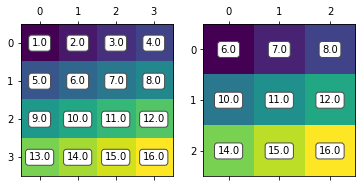

In [120]:
fig, ax = plt.subplots(1,2)
ax[0].matshow(x.squeeze())
for (i, j), z in np.ndenumerate(x.squeeze()):
    ax[0].text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))

ax[1].matshow(y.squeeze())
for (i, j), z in np.ndenumerate(y.squeeze()):
    ax[1].text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))


In [ ]:
init_fun, my_cnn = stax.serial(
    MyConv(out_chan=6, filter_shape=(5, 5), strides=(1, 1), padding="VALID"), Relu,
    MaxPool(window_shape=(2, 2), strides=(1, 1), padding="VALID", spec="NCHW"),
    MyConv(out_chan=16, filter_shape=(5, 5), strides=(1, 1), padding="VALID"), Relu,
    MaxPool(window_shape=(2, 2), strides=(1, 1), padding="VALID", spec="NCHW"),
    Flatten,
    Dense(10), LogSoftmax)


In [ ]:
num_epochs=20
train_loss_1, val_loss_1, train_acc_1, test_acc_1, params_fit_1 = process(my_cnn, init_fun, num_epochs=num_epochs)

  0%|          | 0/20 [00:00<?, ?it/s]

2022-09-01 11:23:05.431944: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:212] Failed to find best cuBLAS algorithm, GEMM performance might be suboptimal: INTERNAL: All algorithms tried for %cublas-gemm.3 = f32[100,10]{1,0} custom-call(f32[100,5184]{1,0} %bitcast.5, f32[5184,10]{1,0} %Arg_4.5, f32[100,10]{1,0} %broadcast.158), custom_call_target="__cublas$gemm", metadata={op_name="jit(update)/jit(main)/add" source_file="/tmp/ipykernel_1403/1061998137.py" source_line=14}, backend_config="{\"alpha_real\":1,\"alpha_imag\":0,\"beta\":1,\"dot_dimension_numbers\":{\"lhs_contracting_dimensions\":[\"1\"],\"rhs_contracting_dimensions\":[\"0\"],\"lhs_batch_dimensions\":[],\"rhs_batch_dimensions\":[]},\"batch_size\":\"1\",\"lhs_stride\":\"518400\",\"rhs_stride\":\"51840\"}" failed. Falling back to default algorithm.  Per-algorithm errors:
2022-09-01 11:23:05.434133: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gemm_algorithm_picker.cc:212]

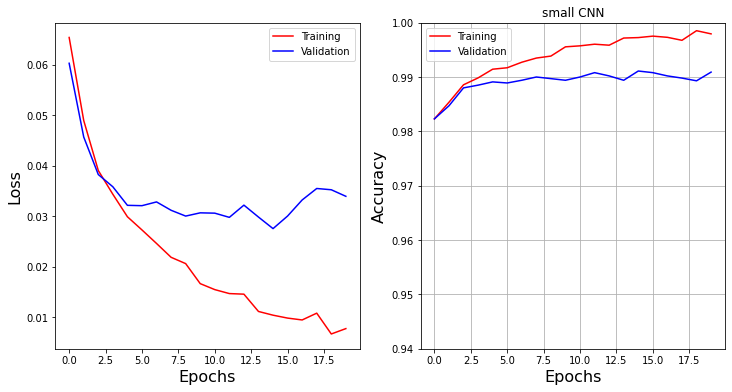

In [ ]:
plot(num_epochs, train_loss_1, val_loss_1, train_acc_1, test_acc_1, 
         model_name="small CNN")